<a href="https://colab.research.google.com/github/dmill166/datamining-learning/blob/main/Songs_Classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preamble**

**Title**: *Spotify Song Tracks Classifier*

**Author**: *Dakota M. Miller*

**Email**: *dmil166 @ msudenver.edu*

**Last Update**: *2021-11-14*

# **Introduction**

The goal of this analysis is to develop classification models capable of predicting the genre of a song based on measured audio attributes.


# **Dataset**

The dataset for this project is available under 'data' (genres_v2.csv) and it was obtained from [Kaggle](https://www.kaggle.com/mrmorj/dataset-of-songs-in-spotify). It consists of a collection of 42,305 song track from various musical genres, with the following audio attributes:

* danceability
* energy
* key
* loudness
* speechiness
* acousticness
* instrumentalness
* liveness
* valence
* tempo
* duration_ms

The meaning of those audio attributes are described by Spotify [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

```
[
danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0.831,0.8140000000000001,2,-7.364,1,0.42,0.0598,0.0134,0.0556,0.389,156.985,audio_features,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/audio-analysis/2Vc6NJ9PW9gD9q343XFRKx,124539,4,Dark Trap,Mercury: Retrograde,,
0.7190000000000001,0.493,8,-7.23,1,0.0794,0.401,0.0,0.11800000000000001,0.124,115.08,audio_features,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/audio-analysis/7pgJBLVz5VmnL7uGHmRj6p,224427,4,Dark Trap,Pathology,,
.
.
.
0.529,0.945,9,-5.862,1,0.0615,0.00189,5.45e-05,0.414,0.134,155.047,audio_features,6MAAMZImxcvYhRnxDLTufD,spotify:track:6MAAMZImxcvYhRnxDLTufD,https://api.spotify.com/v1/tracks/6MAAMZImxcvYhRnxDLTufD,https://api.spotify.com/v1/audio-analysis/6MAAMZImxcvYhRnxDLTufD,162161,4,hardstyle,,20999.0,Best of Hardstyle 2020
]
```

# **Configuration & Data Collection**

## Library Imports

In [21]:
import csv
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sb
import statistics as stats
import sys

## Definitions/Parameters


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Resources

*   [Learn how to import files into Google Colab](https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971)
*   [Troubleshoot dropping dataframe columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) and [again](https://stackoverflow.com/questions/38288372/unable-to-drop-a-column-from-pandas-dataframe)
*   [Affect a column of a dataframe with a function](https://stackoverflow.com/questions/34962104/how-can-i-use-the-apply-function-for-a-single-column)
*   [Extracting unique values and positions from NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.unique.html)
*   [Used a mix of this site and another I can't find now to figure how to split into multiple sub-arrays based on genre](https://numpy.org/devdocs/reference/generated/numpy.unique.html)
*   [Located resource to accurately express myself during this project](https://looks.wtf/flipping-tables)
*   [Researched transpose function for iterative collection building](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.transpose.html)
*   [Leveraged NumPy to calculate attribute statistics, including q1 and q3](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html)
*   [Found online guide and modified approach to generate list of outliers](https://blog.finxter.com/how-to-find-outliers-in-python-easily/)
*   Coworker suggestion to use pandas for the histogram production and seaborn library for correlation analysis
    * [Seaborn pairplot documentation](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

# **Preprocessing**

This section should contain one or more markdown text with supporting code explaining how the dataset was processed before the analysis, including attributes removal, attributes enconding, and any transformations perfomed in the original dataset.


## Specific Preprocessing:
* Remove column 'type'
    * This column only had one value across all records and would not offer meaningful progress towards classification
* Remove columns 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title'
    * Many of these are either unique identifiers or offer other meaning (such as locations on the web) that should not be used for classification purposes
* Prepared data for use in Summary Statistics as well as boxplot generation through list comprehension and iteration

In [3]:
# Read in csv as pandas dataframe
spotify_df = pd.read_csv('/content/drive/My Drive/genres_v2.csv')

# Delete unnecessary columns
spotify_df.drop(columns=['type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature', 'song_name', 'Unnamed: 0', 'title'], axis=1, inplace=True)

# Capture column headers into a Python list
col_headers = spotify_df.columns.to_list()
attr_headers = col_headers[0:-1]

# Capitalize genres, then sort dataframe by this column. Extract unique list of genres
spotify_df['genre'] = spotify_df['genre'].map(lambda genre: genre.upper())
genres_list = list(spotify_df['genre'].unique())
genres_list.sort()
spotify_df.sort_values('genre', inplace=True)

# Convert data to NumPy Array and confirm genre sorting is still in place
spotify_nparray = spotify_df.to_numpy()

# Capture unique genres (mainly for indices)
genres_nparray, indices = np.unique(spotify_nparray[:, -1], return_index=True)

# Split large NumPy Array into sub-arrays by genre
genres_nparray_list = np.array_split(spotify_nparray, indices)
all_genres_nparrays_list = []
for x in genres_nparray_list[1:]:
  all_genres_nparrays_list.append(np.array(x))

# Pivot genre sub-array for each attribute,
# Append results to list of lists of values (attribute lists of genre lists of metric data)
genre_attr_index = 0
all_attribute_genre_data = [[ [] for _ in range(len(genres_list)) ] for _ in range (len(attr_headers)) ]
# histogram_attribute_lists2 = [[] for _ in all_attribute_genre_data] #approach to simplify aggregations into one pass over the data

# Generates transposed data for purposes of boxplot iteration
for a in all_genres_nparrays_list:
  attr_iter_index = 0 
  metrics = all_genres_nparrays_list[genre_attr_index]
  for row in metrics.transpose()[:-1]:
    all_attribute_genre_data[attr_iter_index][genre_attr_index] = list(row)
    # histogram_attribute_lists2[attr_iter_index].append(list(row))
    attr_iter_index += 1
  genre_attr_index += 1

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Summary Statistics, Boxplots, and Histograms**

this section should present the python code that displays summary statistics and visuals from each of the attributes of the dataset; at minimum, a histogram and a multi box plot (per genre) should be produce per attribute.


## Summary Stats


In [ ]:
# Establish indices for iterating in summary statistic production
col_index = 0
genre_index = 0

# Iterate through each genre set of attributes
while genre_index < len(all_genres_nparrays_list):
  print('\n\nSUMMARY STATISTICS FOR', genres_list[genre_index], '\n')
  current_genre_nparray = all_genres_nparrays_list[genre_index]
  genre_outliers_tuple = []
  
  # For each attribute, calculate and output summary statistics
  while col_index < (len(col_headers) - 1): #remove 1 for genres
    temp_array = current_genre_nparray[:, col_index]
    current_attribute = col_headers[col_index].upper()
    print('*** Summary Statistics of Attribute: ' + current_attribute + ' ***')
    attribute_min = '{:,.3f}'.format(np.min(temp_array))
    attribute_max = '{:,.3f}'.format(np.max(temp_array))
    print(f'{current_attribute} Range: [{attribute_min} , {attribute_max}]')
    attribute_mean = '{:,.3f}'.format(np.mean(temp_array))
    print(f'{current_attribute} Mean: {attribute_mean}')
    attribute_median = '{:,.3f}'.format(np.median(temp_array))
    print(f'{current_attribute} Median: {attribute_median}')
    attribute_std = '{:,.3f}'.format(np.std(temp_array))
    print(f'{current_attribute} StD: {attribute_std}')
    col_index += 1
  genre_index += 1
  col_index = 0

## Boxplots

In [ ]:
# Iterate through prep'd attribute-genre 2d array of metrics and data for boxplots
attr_str_index = 0
for attribute_metrics in all_attribute_genre_data:
  data = all_attribute_genre_data[attr_str_index]
  print('data:', data)
  medians = [ stats.median(branch) for branch in data ]
  plt.boxplot(
      data, vert=False
  )
  i = 0
  branch_labels = []
  for branch in data:
    max_value = max(branch)
    branch_labels.append(genres_list[i])
    i += 1
  axes = plt.gca()
  axes.spines['right'].set_visible(False)
  axes.spines['top'].set_visible(False)
  axes.set_yticklabels(branch_labels)
  plt.xlabel(attr_headers[attr_str_index])
  plt.show()
  attr_str_index += 1

## Histograms

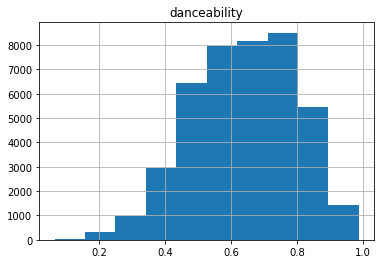

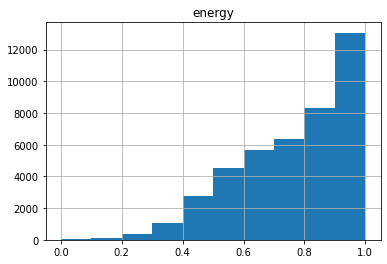

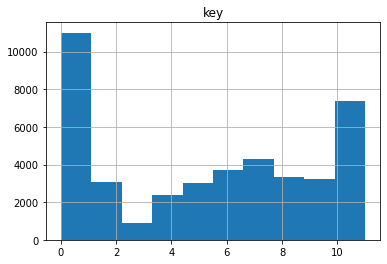

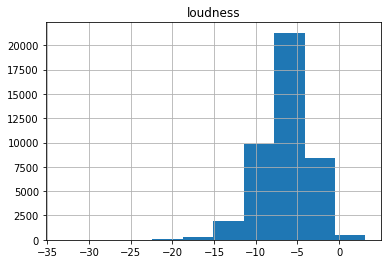

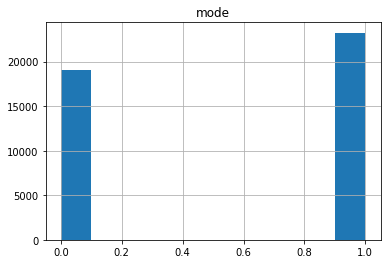

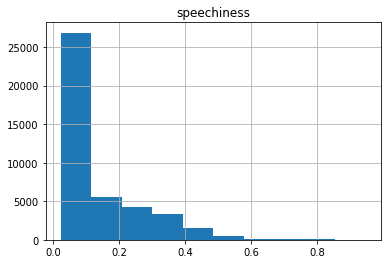

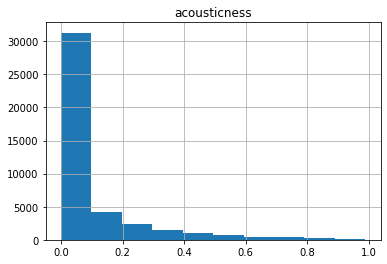

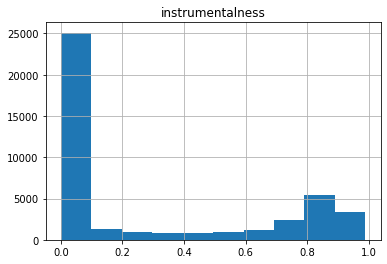

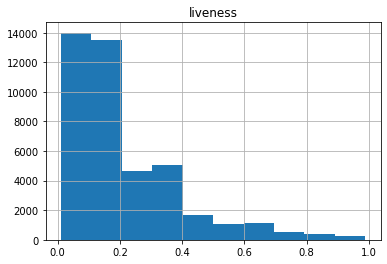

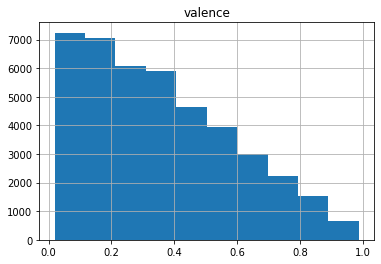

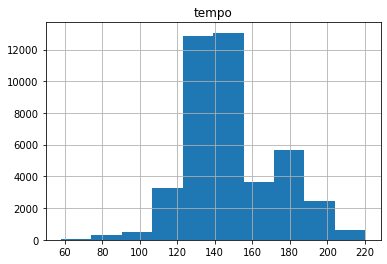

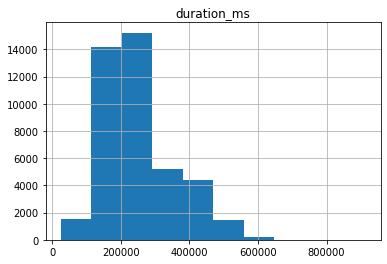

In [18]:
#TODO
for attr in attr_headers:
  plt.figure()
  spotify_df[attr].hist()
  plt.title(attr)
  plt.show()

# **Correlation Analysis**

do at least one correlation analysis, like comparing speechiness and instrumentalness, for example.


## SECTION_HEADER_HERE

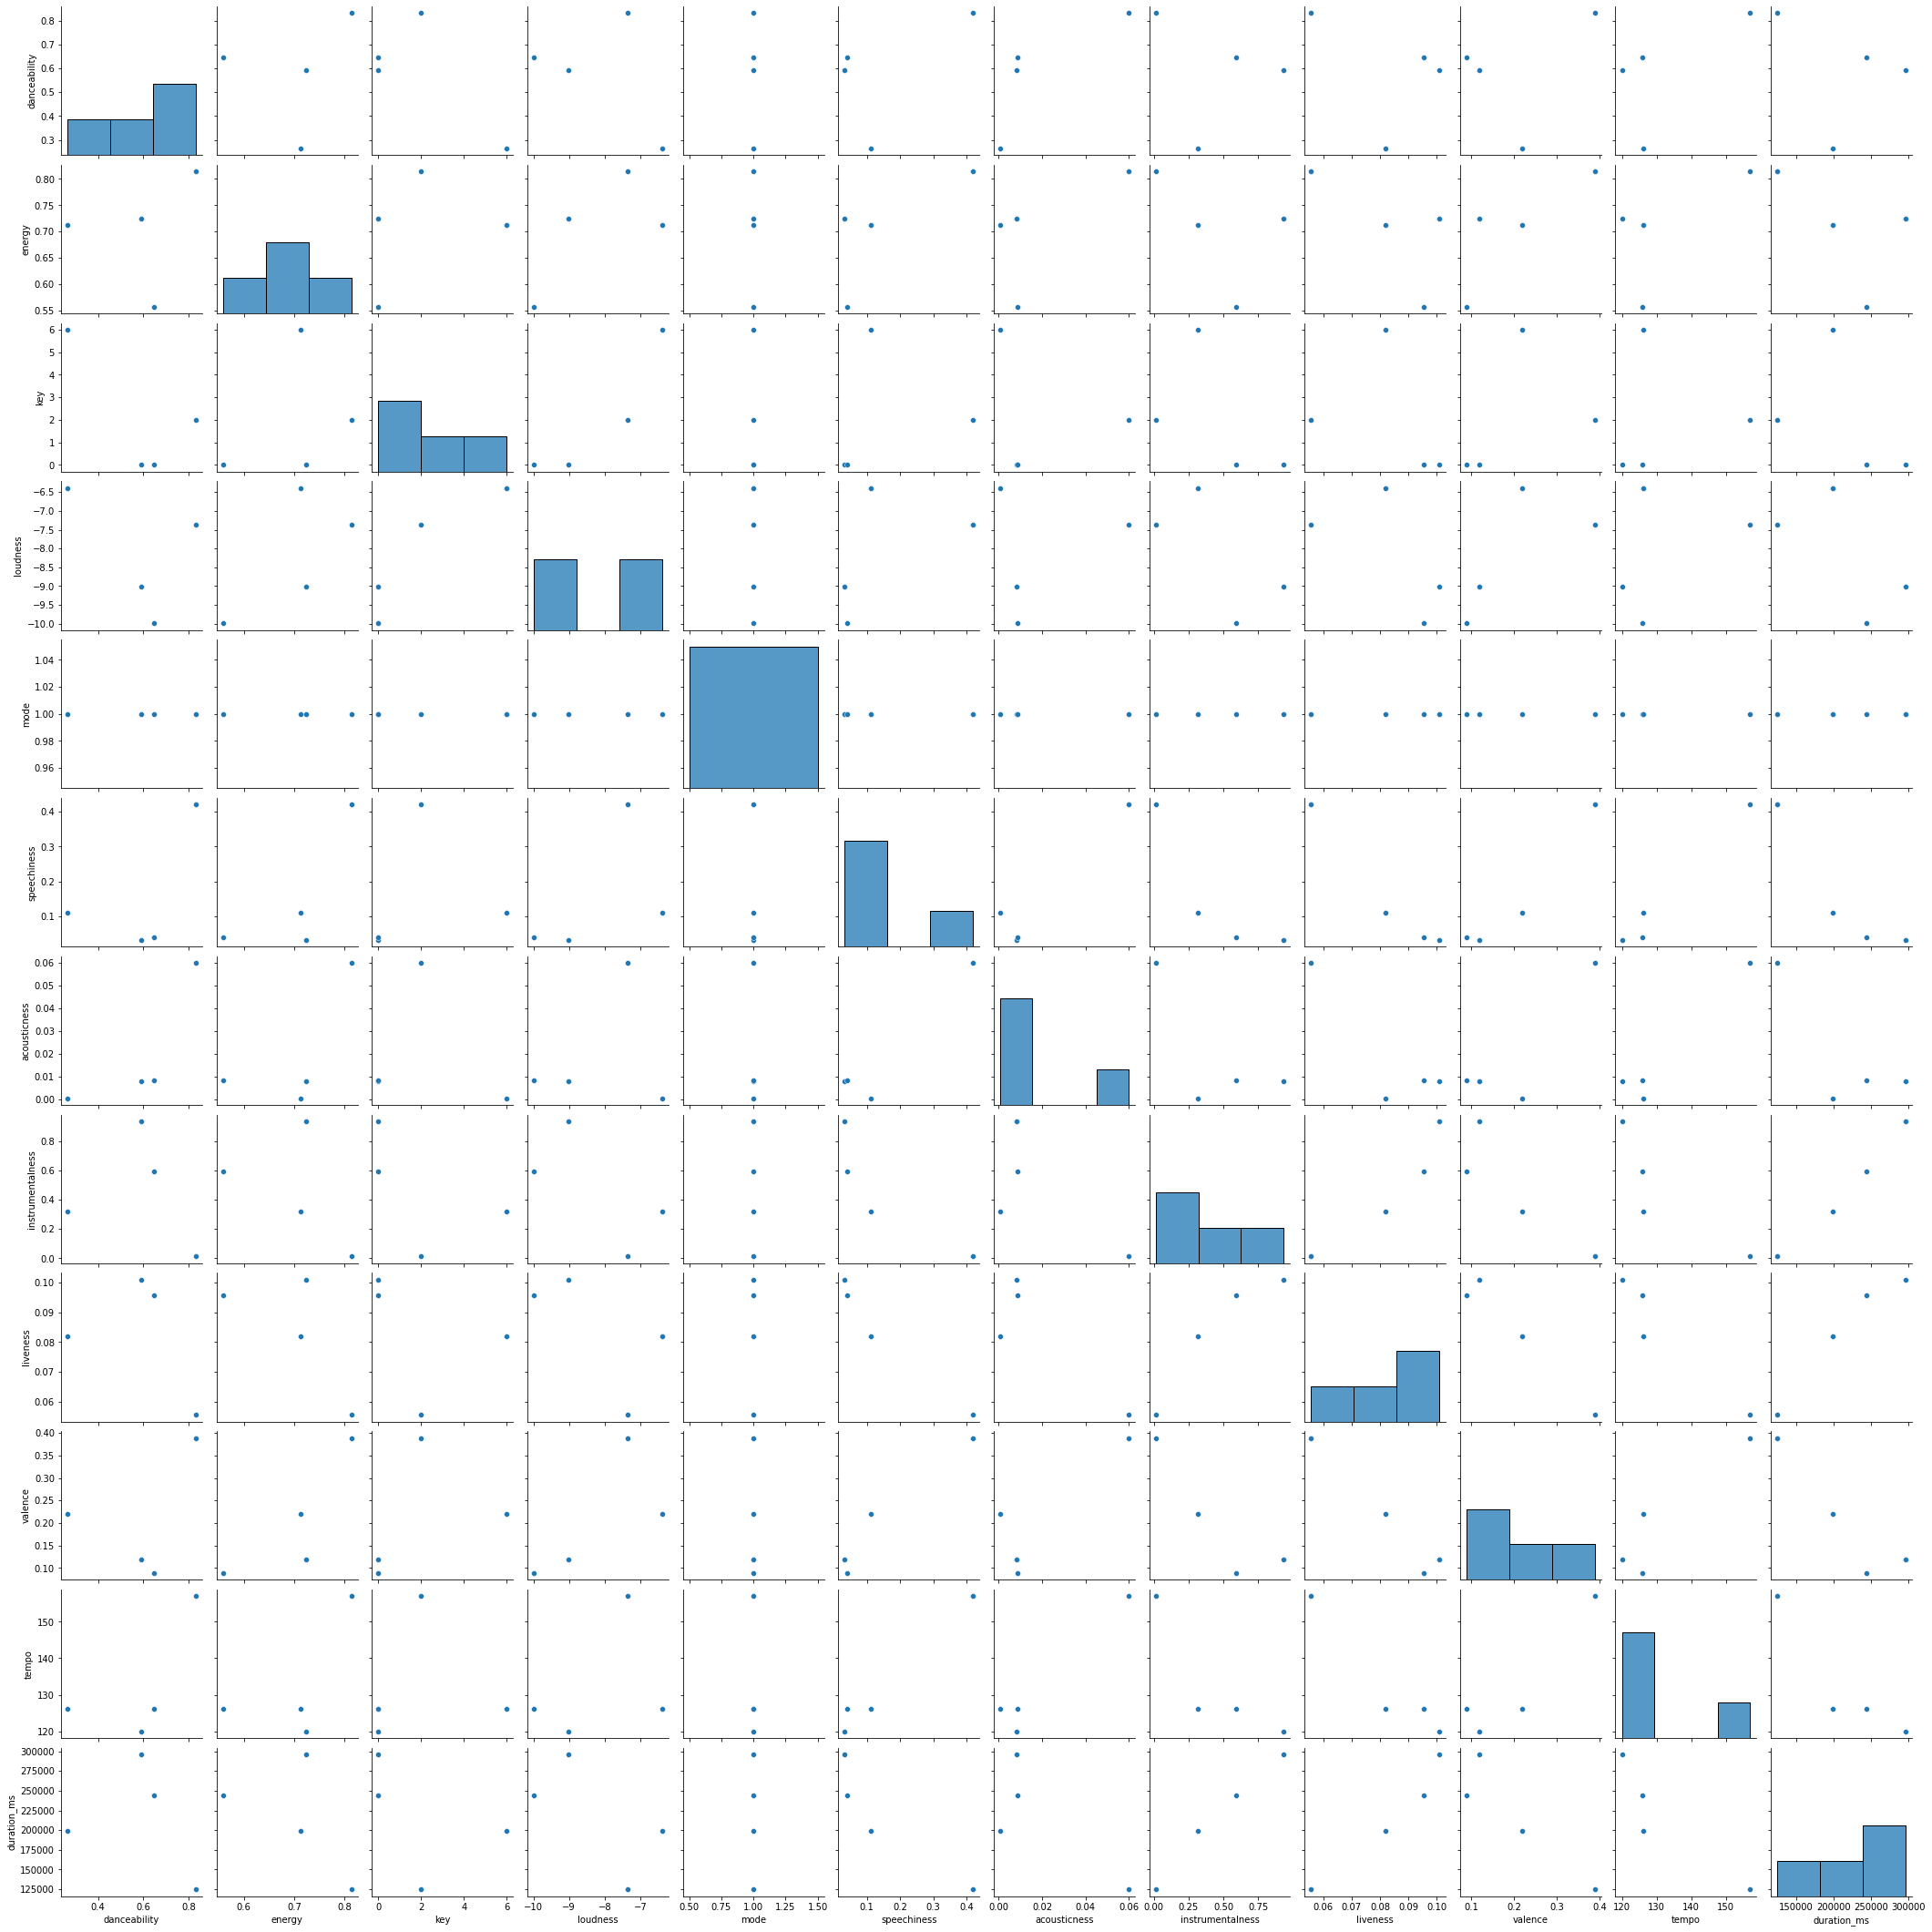

In [26]:
# Correlation analysis on first four attributes
sb.pairplot(spotify_df[0:4])

# **Classification**

show the code and results of 3 classification models based on decision tree inference, naive Bayes classification, and artificial neural networks; each classification model should be based on a consistent split between training and testing datasets; the accuracy of each model should be displayed; any specific tunning parameter used in a model should be supported by an explanatory text.


## SECTION_HEADER_HERE

In [8]:
#%%

# TODO: